### Wine Recommender System

1. Content Based Filtering - Recommend by similarity based on variety and reviews

Reference
- https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system/notebook
- https://www.youtube.com/watch?v=TNcfJHajqJY&t=8s
- https://www.kaggle.com/code/kaitlynchoi/wine-recommendation-using-tf-idf
- https://towardsdatascience.com/content-based-recommender-systems-28a1dbd858f5


### 1. Variety Recommender

In [1]:
# library
# Importing Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [2]:
# Dataset
wines2 = pd.read_csv('datasets/winemag-data-130k-v2.csv')
wines2.sample(5)  # breifly check the data

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
19456,19456,France,"Composed of 60% Grenache and 40% Syrah, here's...",NaN,87,11.0,Languedoc-Roussillon,Vin de Pays des Côtes Catalanes,NaN,Lauren Buzzeo,@laurbuzz,Cuvée de Peña 2009 Rosé (Vin de Pays des Côtes...,Rosé,Cuvée de Peña
16673,16673,France,"Light in color, this wine seems already mature...",Côte du Py,85,28.0,Beaujolais,Morgon,NaN,Roger Voss,@vossroger,Domaine de la Bonne Tonne 2013 Côte du Py (Mo...,Gamay,Domaine de la Bonne Tonne
115023,115023,US,"Firm, hard and tight, this offers black cherry...",Genesis,87,16.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Hogue 2008 Genesis Merlot (Columbia Valley (WA)),Merlot,Hogue
19027,19027,US,This is a big but balanced expression of Caber...,NaN,93,18.0,California,Central Coast,Central Coast,Matt Kettmann,@mattkettmann,Smith & Hook 2015 Cabernet Sauvignon (Central ...,Cabernet Sauvignon,Smith & Hook
57397,57397,US,"This is a Petite Sirah that's easy to love, ri...",NaN,88,18.0,California,Mendocino County,NaN,Virginie Boone,@vboone,Graziano 2009 Petite Sirah (Mendocino County),Petite Sirah,Graziano


### Wine recommendation by variety

- Content Based Filtering: using cosine similarity
- Using variety and description(review)
- *CountVectorizer*, *TfidfTransformer*
    - Get a commonly used words in the reviews on the same variety

In [3]:
variety_df = wines2[["variety", "description"]]

# Drop duplicated or NAs
variety_df = variety_df.drop_duplicates().dropna()
variety_df.head()


,variety,description
0,White Blend,"Aromas include tropical fruit, broom, brimston..."
1,Portuguese Red,"This is ripe and fruity, a wine that is smooth..."
2,Pinot Gris,"Tart and snappy, the flavors of lime flesh and..."
3,Riesling,"Pineapple rind, lemon pith and orange blossom ..."
4,Pinot Noir,"Much like the regular bottling from 2012, this..."


In [4]:
variety_df.shape

(119964, 2)

In [5]:
# number of unique varieties
len(variety_df["variety"].unique().tolist())

707

In [6]:
# Count the number of reviews per grape variety
variety_rev_num = variety_df["variety"].value_counts()

rev_num_df = pd.DataFrame({"variety":variety_rev_num.index, 'rev_num':variety_rev_num.values})

<BarContainer object of 20 artists>

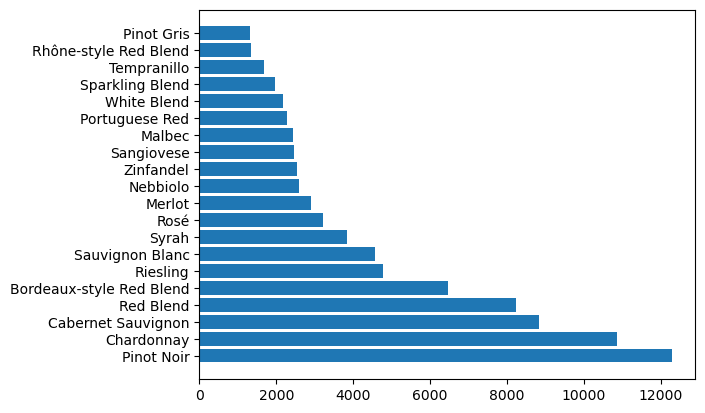

In [7]:
# Showing the number of reviews per variety for the top 20 wines
common_varieties = variety_rev_num.iloc[:20]

plt.barh(common_varieties.index, common_varieties.values)

In [8]:
# Seperate varieties which have more than one review, and only have one review
multi_rev_variety = rev_num_df[(rev_num_df["rev_num"]>1)]["variety"].tolist()
one_rev_variety = rev_num_df[(rev_num_df["rev_num"]==1)]["variety"].tolist()

In [9]:
# set index
variety_df = variety_df.set_index("variety")

variety_df

,description
variety,
White Blend,"Aromas include tropical fruit, broom, brimston..."
Portuguese Red,"This is ripe and fruity, a wine that is smooth..."
Pinot Gris,"Tart and snappy, the flavors of lime flesh and..."
Riesling,"Pineapple rind, lemon pith and orange blossom ..."
Pinot Noir,"Much like the regular bottling from 2012, this..."
...,...
Riesling,Notes of honeysuckle and cantaloupe sweeten th...
Pinot Noir,Citation is given as much as a decade of bottl...
Gewürztraminer,Well-drained gravel soil gives this wine its c...


In [10]:
# TfidfTransformer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


variety_df2 = pd.DataFrame(columns = ["variety", "description"])

# CountVectorizer object, using 'english' as stopwords 
cv = CountVectorizer(stop_words = "english", ngram_range=(2,2))

# TfidTransformer object
tfidf_transformer = TfidfTransformer(smooth_idf = True, use_idf = True)

for grape in multi_rev_variety:
    df = variety_df.loc[[grape]]
    
    # Word counts for the words used in the reviews of a specific  variety
    word_count = cv.fit_transform(df["description"])
    
    # Compute IDF values
    tfidf_transformer.fit(word_count)
    
    # Get top 100 common words (low IDF values) used in the reviews
    df_idf = pd.DataFrame(tfidf_transformer.idf_, index = cv.get_feature_names_out(), columns = ["idf_weights"])
    df_idf.sort_values(by = ["idf_weights"], inplace = True)
    
    # put 100 common words in a list
    common_words = df_idf.iloc[:100].index.tolist()
    
    # Convert the list to a string and create a df 
    common_words_str = ", ".join(elem for elem in common_words)
    new_row = {"variety": grape, "description": common_words_str}
    
    variety_df2 = pd.concat([variety_df2, pd.DataFrame([new_row])], ignore_index=True)

In [11]:
variety_df2

,variety,description
0,Pinot Noir,"pinot noir, black cherry, cherry fruit, fruit ..."
1,Chardonnay,"buttered toast, fruit flavors, tropical fruit,..."
2,Cabernet Sauvignon,"black cherry, cabernet sauvignon, black curran..."
3,Red Blend,"cabernet sauvignon, black cherry, palate offer..."
4,Bordeaux-style Red Blend,"cabernet sauvignon, black currant, cabernet fr..."
...,...,...
549,Shiraz-Cabernet,"45 cabernet, molasses cedar, mouthwatering ele..."
550,Cabernet Franc-Carmenère,"aromas come, keeps form, latex mild, lean frui..."
551,Fer Servadou,"bright fruity, acidity cuts, produced bright, ..."
552,Lambrusco Salamino,"100 lambrusco, informal wine, lambrusco salami..."


In [12]:
# Set index
variety_df2 = variety_df2.set_index("variety")
variety_df2

,description
variety,
Pinot Noir,"pinot noir, black cherry, cherry fruit, fruit ..."
Chardonnay,"buttered toast, fruit flavors, tropical fruit,..."
Cabernet Sauvignon,"black cherry, cabernet sauvignon, black curran..."
Red Blend,"cabernet sauvignon, black cherry, palate offer..."
Bordeaux-style Red Blend,"cabernet sauvignon, black currant, cabernet fr..."
...,...
Shiraz-Cabernet,"45 cabernet, molasses cedar, mouthwatering ele..."
Cabernet Franc-Carmenère,"aromas come, keeps form, latex mild, lean frui..."
Fer Servadou,"bright fruity, acidity cuts, produced bright, ..."


In [13]:
# Add one review variety
variety_df2 = pd.concat([variety_df2, variety_df.loc[one_rev_variety]])
variety_df2

,description
variety,
Pinot Noir,"pinot noir, black cherry, cherry fruit, fruit ..."
Chardonnay,"buttered toast, fruit flavors, tropical fruit,..."
Cabernet Sauvignon,"black cherry, cabernet sauvignon, black curran..."
Red Blend,"cabernet sauvignon, black cherry, palate offer..."
Bordeaux-style Red Blend,"cabernet sauvignon, black currant, cabernet fr..."
...,...
Cabernet Sauvignon-Barbera,"One of the last ‘98s to be released, and still..."
Merlot-Shiraz,Sweet and floral with assertive aromas of crus...
Folle Blanche,This is classic wine drunk in the bars of Nant...


In [14]:
# TF-IDF = TF*IDF
# It will be high if the term is unique(IDF) in the whole document and the term appeared frequently in a description(TF)
from sklearn.feature_extraction.text import TfidfVectorizer

# stopwords
tfidf = TfidfVectorizer(ngram_range=(2,2), stop_words = "english")

# Count the words in each review, calculate idf, and multiply tf by idf
tfidf_matrix = tfidf.fit_transform(variety_df2["description"])

# We have converted the text into a matrix of Tfidf values
tfidf_matrix.shape

(707, 60740)

In [15]:
# Now, we can use Cosine Similarity: use the angle between variables to indicate how close and far they are
# linear_kernel is same as sklearn's cosine_similarity

# import linear kernel
from sklearn.metrics.pairwise import linear_kernel

In [16]:
# compute cosine similarity in the reviews
cos_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# reset index to put variety 
variety_df2 = variety_df2.reset_index()
indices = pd.Series(variety_df2.index, index = variety_df2["variety"])

In [17]:
# Recommendation function 
def recommend_variety(grape, cos_sim = cos_sim):
    index = indices[grape]
    
    cos_sim_scores = list(enumerate(cos_sim[index]))
    
    # sort wines by similarity 
    cos_sim_scores = sorted(cos_sim_scores, key = lambda x:x[1], reverse = True)
    
    # select top 5 
    cos_sim_scores = cos_sim_scores[1:6]
    wine_index_lst = [i[0] for i in cos_sim_scores]
    
    # create output df
    output_df = pd.DataFrame(columns = ["Variety recommendation", "Top 5 common words in wine reviews"])
    
    for wine_index in wine_index_lst:
        wine_variety = variety_df2.iloc[wine_index]["variety"]
        
        top_common_words = variety_df2.iloc[wine_index]["description"]
        
        if wine_variety in multi_rev_variety:
            top_common_words_splt = top_common_words.split(", ")
            key_words_lst = top_common_words_splt[:5]
            key_words_str = ", ".join(key_words_lst)
        else:
            key_words_str = top_common_words
        
        new_row = {"Variety recommendation": wine_variety, "Top 5 common words in wine reviews": key_words_str}
        output_df = pd.concat([output_df, pd.DataFrame([new_row])], ignore_index = True)
    
    output_df.set_index("Variety recommendation")
    
    pd.set_option("max_colwidth", 500)
    
    return output_df
        

In [18]:
recommend_variety("Pinot Noir")

,Variety recommendation,Top 5 common words in wine reviews
0,Merlot,"black cherry, fruit flavors, red fruit, medium bodied, cherry flavors"
1,Grenache,"fruit flavors, red fruit, white pepper, red cherry, cherry fruit"
2,Cabernet Franc,"cabernet franc, cab franc, black cherry, fruit flavors, red cherry"
3,Syrah,"black pepper, fruit flavors, black cherry, black fruit, smoked meat"
4,Tempranillo,"berry aromas, berry flavors, black fruit, flavors finish, fruit flavors"


In [19]:
variety_df2

,variety,description
0,Pinot Noir,"pinot noir, black cherry, cherry fruit, fruit flavors, raspberry cherry, red cherry, red fruits, red fruit, medium bodied, cherry flavors, cherry cola, black tea, red berry, forest floor, french oak, cherry raspberry, raspberries cherries, single vineyard, bodied wine, silky texture, red currant, nose bottling, ready drink, raspberry fruit, drink 2018, firm tannins, red plum, wine shows, rose petals, new french, berry fruit, drink 2020, spice flavors, cherry pie, crisp acidity, dry silky, co..."
1,Chardonnay,"buttered toast, fruit flavors, tropical fruit, green apple, apple pear, medium bodied, ready drink, crisp acidity, yellow fruits, apple flavors, white peach, pear flavors, french oak, stone fruit, tropical fruits, meyer lemon, bodied wine, baked apple, creamy texture, wine offers, lemon lime, citrus flavors, drink 2018, wine shows, ripe fruit, peach flavors, wood aging, drink 2017, new oak, yellow fruit, nose bottling, nose palate, crème brûlée, aromas flavors, ripe yellow, vanilla flavors, ..."
2,Cabernet Sauvignon,"black cherry, cabernet sauvignon, black currant, fruit flavors, black fruit, dark chocolate, petit verdot, blackberry cherry, black currants, black pepper, oak flavors, cherry flavors, medium bodied, blackberry black, 100 varietal, red fruit, firm tannins, smoky oak, flavors blackberries, 100 cabernet, french oak, dark fruit, dried herb, berry flavors, cabernet franc, blackberries cherries, currant flavors, cherry cassis, blackberry currant, new oak, varietal wine, berry aromas, red currant,..."
3,Red Blend,"cabernet sauvignon, black cherry, palate offers, cabernet franc, petit verdot, palate delivers, fruit flavors, black fruit, black pepper, petite sirah, opens aromas, white pepper, blend cabernet, merlot cabernet, grained tannins, sauvignon merlot, red berry, tannins drink, blend sangiovese, ripe black, black currant, lead nose, baking spice, fine grained, black plum, blue flower, red cherry, red fruit, dried black, aromas black, medium bodied, polished tannins, berry flavors, palate doles, f..."
4,Bordeaux-style Red Blend,"cabernet sauvignon, black currant, cabernet franc, petit verdot, barrel sample, fruit flavors, firm tannins, berry fruits, ready drink, black fruits, drink 2018, wood aging, black fruit, fruity wine, drink 2017, red berry, bordeaux style, black plum, merlot cabernet, drink 2019, new wood, style blend, structured wine, ripe fruit, ripe wine, currant fruits, currant fruit, black cherry, dry tannins, drink 2020, currant flavors, wine shows, blend cabernet, blackberry fruits, bordeaux blend, win..."
...,...,...
702,Cabernet Sauvignon-Barbera,"One of the last ‘98s to be released, and still dark in color. The tannins are hefty, although they're of the soft, pliant kind, and acidity is low. Oak overshadows the fruit. Not offering much now, and doesn't seem to be an ager."
703,Merlot-Shiraz,"Sweet and floral with assertive aromas of crushed violets, dark berries and a touch of milk chocolate. Easy in the mouth with a medium weight, round texture and soft tannins. The finish is loaded with juicy black fruit flavors. Drink now."
704,Folle Blanche,"This is classic wine drunk in the bars of Nantes with oysters. It is so crisp, light with an almost shocking amount of acidity. It is very fresh, with strong citrus fruit and just a light prickle on the tongue. Drink now."
705,Forcallà,"Hard, rubbery cherry and berry aromas lead to a raw, underdeveloped palate. This wine made from the local Valencia-region grape variety Forcallà is outright tart and tomatoey, with a touch of red-plum flavor. An herbal, rubbery, tannic finish tastes saucy."


In [20]:
recommend_variety("Merlot-Shiraz")

,Variety recommendation,Top 5 common words in wine reviews
0,Rhône-style Red Blend,"black cherry, finish drink, fruit flavors, cherry fruit, black pepper"
1,Blaufränkisch,"black cherry, white pepper, nose palate, cherry fruit, red cherry"
2,Chelois,"accented ginger, hints mushroom, hybrid variety, leads hint, lends balance"
3,Grenache-Syrah,"black cherry, grenache syrah, 40 syrah, finish drink, grenache 40"
4,Carignan,"plum berry, berry aromas, finish drink, fruit flavors, berry fruits"
